<center><h1>Analysis of Iris Dataset</h1></center>

<center>Glen Frost</center>

## Table of Contents
* [Introduction](#introduction)
* [Preliminaries](#preliminaries)
  * [Load Libraries](#load-libraries)
  * [Load Data](#load-data)
  * [Inspect Data](#inspect-data)
  * [Check Missing Values](#check-missing-values)
* [Exploratory Data Analysis](#EDA)
  * [Summary Statistics](#summary-statistics)
  * [Classical Visualization](#classical-visualization)
  * [(Linear) Dimension Reduction: PCA](#PCA)
  * [(Nonlinear) Dimension Reduction: t-SNE](#TSNE)
* [Constructing Models](#constructing-models)
  * [Preprocessing](#preprocessing)
    * [Train-Test-Split](#train-test-split)
    * [Encoding Categorical Features](#encoding)
  * [Multinomial Logistic Regression](#logistic)
  * [Decision Tree](#decision-tree)
  * [XGBoost](#xgboost)
* [Model Evaluation and Selection](#evaluation)
* [Further Directions](#conclusion)

## Introduction <a class="anchor" id="introduction"></a>

In this notebook we study the famous _Iris_ flower data set.  The data set contains of 150 observations of Iris plants with the attributes:
  + Sepal Length (in cm)
  + Sepal Width (in cm)
  + Petal Length (in cm)
  + Petal Width (in cm)
  + Species
     + Iris Setosa
     + Iris Versicolour
     + Iris Virginica
     
The goal is to predict the class of an observation from the four measurements.  It is well known that one class is linearly separable from the other two, while the other two are not linearly separable from each other.  We hope to observe this phenomenon in our analysis.

We will analyze the data using standard Python libraries for data handling, visualizing and modeling.  We begin with classical statistics and visuals followed by the dimensional reduction techniques PCA and t-SNE.  We train and test three models: multinomial logistic regression, decision tree and XGBoost.

## Preliminaries <a class="anchor" id="preliminaries"></a>

### Load Libraries <a class="anchor" id="load-libraries"></a>

Load the required libraries:

In [1]:
# data handling
import numpy as np
import pandas as pd
# visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# dimension reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.tree import plot_tree
import xgboost as xgb
# evaluation
from sklearn.model_selection import cross_val_score

### Load Data <a class="anchor" id="load-data"></a>

The data is given as a `.csv` file which we load as follows:

In [3]:
iris = pd.read_csv('./data/IRIS.csv')

### Inspect Data <a class="anchor" id="inspect-data"></a>

Let us preview the data to see what we are working with:

In [4]:
iris.head(5)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
iris.shape

(150, 6)

There are 150 observations with 6 features.  One of these is the target feature `Species`.  We will drop the feature `Id` since it is not relevant to our analysis and only leads to various indexing errors later.

In [6]:
iris = iris.drop(['Id'], axis=1)

Preview the data after the drop to check correctness:

In [7]:
iris.head(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Split the data into `X` and `y` values:

In [8]:
X = iris.iloc[:,0:-1]
y = iris.iloc[:,-1:]

Preview the split data to ensure the split was made correctly:

In [9]:
X.head(5), y.head(5)

(   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
 0            5.1           3.5            1.4           0.2
 1            4.9           3.0            1.4           0.2
 2            4.7           3.2            1.3           0.2
 3            4.6           3.1            1.5           0.2
 4            5.0           3.6            1.4           0.2,
        Species
 0  Iris-setosa
 1  Iris-setosa
 2  Iris-setosa
 3  Iris-setosa
 4  Iris-setosa)

### Check Missing Values <a class="anchor" id="check-missing-values"></a>

We check for missing values:

In [10]:
iris.isnull().sum()

SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

Since there are no missing values, no further action is required.

## Exploratory Data Analysis (EDA) <a class="anchor" id="EDA"></a>

### Summary Statistics <a class="anchor" id="summary-statistics"></a>

First we describe the features and their datatypes:

In [11]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


There are 4 numerical features and 1 categorical feature with a total of 150 observations.

Now we calculate the summary statistics:

In [12]:
iris.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


We check the value counts of the target variable and observe that each class contains the same number of observations.

In [13]:
iris["Species"].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: Species, dtype: int64

### Classical Visualizations <a class="anchor" id="classical-visualization"></a>

Consider the following pairwise scatterplots of the numerical features, along with distributions of each variable for each species on the diagonal:

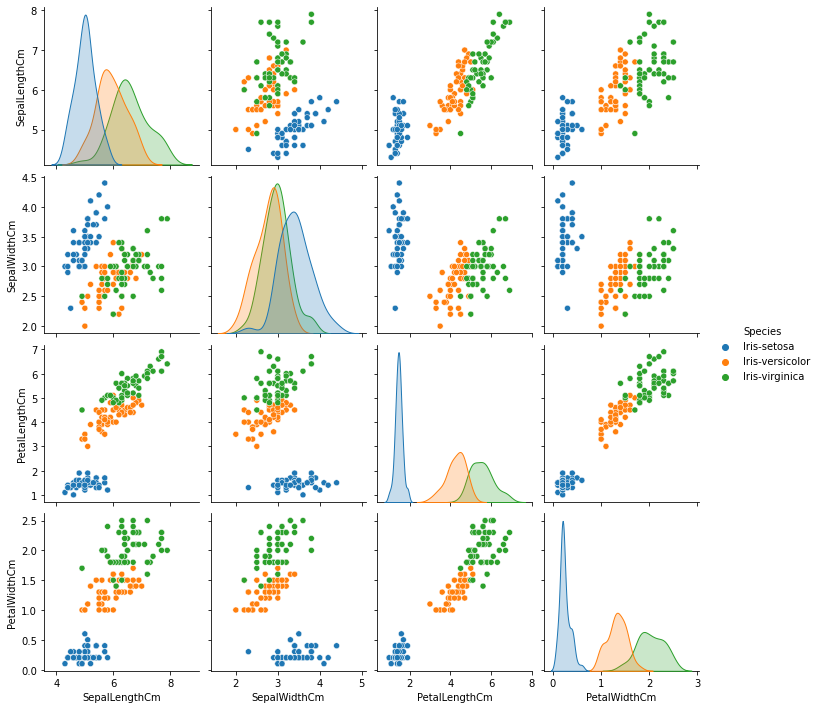

In [14]:
sns.pairplot(data=iris, hue='Species')

We gather observations:
 + Petal properties more clearly distinguish the species, while sepal properties are more mixed.
 + Versicolor and Virginica have similar sepal width, while Virginica has larger measurements for the other properties.
 + Setosa has generally larger sepal width, but smaller measurements than the other two species for the other measurements.

Text(0.5, 1.0, 'Heatmap of Correlations')

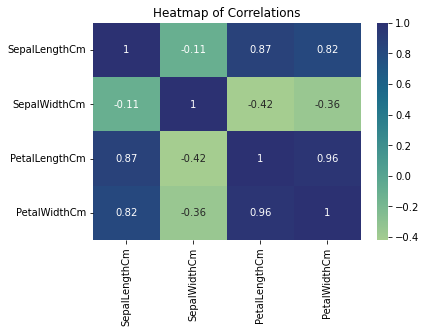

In [15]:
sns.heatmap(X.corr(), annot=True, cmap="crest")
plt.title('Heatmap of Correlations')

We gather observations:
 + Petal length and petal width have the strongest correlation.
 + Sepal length with petal measurements are the next highest correlations.
 + Sepal length and width have weak correlation.

### (Linear) Dimension Reduction: PCA <a class="anchor" id="PCA"></a>

We calculate principal components with 2 dimensions and perform a visualization.

In [16]:
# Intialize PCA with 2 components:
pca = PCA(n_components=2, random_state=0)
# Calculate PCA on X-values of entire dataset:
pca.fit(X)
X_pca_array = pca.transform(X)
# Assemble PCA data into a Pandas DataFrame:
X_pca = pd.DataFrame(X_pca_array, columns=['PC1','PC2'])
# Append 'Species' information:
X_pca['Species'] = y

Text(0.5, 1.0, 'Iris PCA')

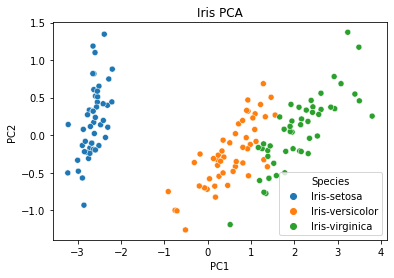

In [17]:
# Create scatterplot using PCA components colored by 'Species':
sns.scatterplot(data=X_pca,
                x=X_pca['PC1'],
                y=X_pca['PC2'],
                hue='Species')
plt.title('Iris PCA')

In [18]:
pca.explained_variance_ratio_

array([0.92461621, 0.05301557])

We gather observations:
 + PCA is a linear model and we see linear separation between setosa and the other two species.
 + Therefore setosa can be linearly separated from the other two species in the original feature space.
 + The first component accounts for 92.5% of the variance and the second component for 5.3%.
 + Thus the two components contain most of the information.

### (Nonlinear) Dimension Reduction: t-SNE <a class="anchor" id="TSNE"></a>

We perform a nonlinear dimensional reduction using t-SNE.  However it is not as simple to draw insights from t-SNE as compared to PCA.

In [19]:
# Initialize t-SNE with 2 components:
tsne = TSNE(n_components=2, random_state=0)
# Fit t-SNE to X-values of entire dataset:
X_tsne_array = tsne.fit_transform(X)
# Process the t-SNE data into a Pandas DataFrame:
X_tsne = pd.DataFrame(X_tsne_array, columns=['TSNE1', 'TSNE2'])
# Append the 'Species' data:
X_tsne['Species'] = y

Text(0.5, 1.0, 'Iris t-SNE Dimension Reduction')

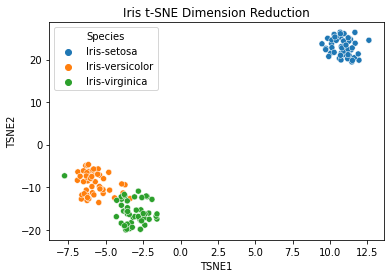

In [20]:
# Create scatterplot using t-SNE components and colored by 'Species':
sns.scatterplot(data=X_tsne,
                x=X_tsne['TSNE1'],
                y=X_tsne['TSNE2'],
                hue='Species')
plt.title('Iris t-SNE Dimension Reduction')

## Constructing Models <a class="anchor" id="constructing-models"></a>

### Preprocessing <a class="anchor" id="preprocessing"></a>

#### Train-Test-Split <a class="anchor" id="train-test-split"></a>

We want to do train-test-split in order to validate and test our models.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Encoding Categorical Features <a class="anchor" id="encoding"></a>

 + We perform one-hot encoding on the feature 'Species' in order to apply XGBoost.
 + We are able to perform multinomial logistic regression and construct the decision tree without encoding.

In [22]:
# Initialize OneHotEncoder:
enc = OneHotEncoder(sparse=False)
# Fit the encoder to the target variable on the ENTIRE data set:
# (Guarantees that the resulting encoding on y_train and y_test will match)
fitted_onehot = enc.fit(y)
# Transform the training y data:
y_train_enc = fitted_onehot.fit_transform(y_train)
# Transform the test y data:
y_test_enc = fitted_onehot.fit_transform(y_test)
# Transform the entire y data:
y_enc = fitted_onehot.fit_transform(y)

### Multinomial Logistic Regression <a class="anchor" id="logistic"></a>

We build and fit a multinomial logistic regression model.  Then we predict on the test set.

In [23]:
# Initialize logistic regression model with 200 max iterations:
model_logistic = LogisticRegression(max_iter=200, random_state=0)
# Fit the logistic model to the training set:
fitted_logistic = model_logistic.fit(X_train, y_train['Species'])

In [24]:
# Use the model to predict on the test set:
y_test_pred_logistic = fitted_logistic.predict(X_test)
# Preview the prediction to check that it makes sense:
y_test_pred_logistic[:10]

array(['Iris-virginica', 'Iris-versicolor', 'Iris-setosa',
       'Iris-virginica', 'Iris-setosa', 'Iris-virginica', 'Iris-setosa',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor'],
      dtype=object)

If needed, we can view the predicted probabilities for each class:

In [25]:
fitted_logistic.predict_proba(X_test)[:5]

array([[1.12201966e-04, 5.89790786e-02, 9.40908719e-01],
       [1.22212570e-02, 9.64562370e-01, 2.32163726e-02],
       [9.86662709e-01, 1.33372584e-02, 3.29542024e-08],
       [1.19478736e-06, 2.31601883e-02, 9.76838617e-01],
       [9.72127685e-01, 2.78721827e-02, 1.31920600e-07]])

### Decision Tree <a class="anchor" id="decision-tree"></a>

We build and fit a decision tree model.  Then we predict on the test set.

Here we are able to explicit visualizations of the model's prediction process.

In [26]:
# Initialize DecisionTree with depth 3
model_tree = DecisionTreeClassifier(random_state=0, max_depth=3)
# Fit the tree to the training set:
fitted_tree = model_tree.fit(X_train, y_train)

In [27]:
# Use the model to predict on the test set:
y_test_pred_tree = fitted_tree.predict(X_test)
# Preview the prediction to check that it makes sense:
y_test_pred_tree[:10]

array(['Iris-virginica', 'Iris-versicolor', 'Iris-setosa',
       'Iris-virginica', 'Iris-setosa', 'Iris-virginica', 'Iris-setosa',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor'],
      dtype=object)

In [28]:
# Generate text representing the decision tree process:
print(export_text(fitted_tree))

|--- feature_3 <= 0.80
|   |--- class: Iris-setosa
|--- feature_3 >  0.80
|   |--- feature_3 <= 1.75
|   |   |--- feature_2 <= 4.95
|   |   |   |--- class: Iris-versicolor
|   |   |--- feature_2 >  4.95
|   |   |   |--- class: Iris-virginica
|   |--- feature_3 >  1.75
|   |   |--- feature_2 <= 4.85
|   |   |   |--- class: Iris-versicolor
|   |   |--- feature_2 >  4.85
|   |   |   |--- class: Iris-virginica



Text(0.5, 1.0, 'Decision tree trained on all iris features')

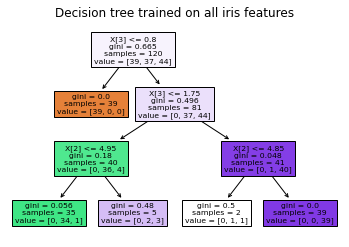

In [29]:
# Plot the decision tree process:
plt.figure()
plot_tree(fitted_tree, filled=True)
plt.title("Decision tree trained on all iris features")

### XGBoost <a class="anchor" id="xgboost"></a>

In [30]:
# Initialize XGB Classifier:
model_xgb = xgb.XGBClassifier(random_state=0)
# Fit the XGB model to the training set:
fitted_xgb = model_xgb.fit(X_train, y_train_enc)

In [31]:
# Use the model to predict on the test set:
y_test_pred_xgb = fitted_xgb.predict(X_test)
# Preview the prediction to check that it makes sense:
y_test_pred_xgb[:10]

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

## Model Evaluation and Selection <a class="anchor" id="evaluation"></a>

For each model we calculate the mean accuracy on the test set and calculate scores for 5-fold cross-validation using the entire data set.

In [32]:
print( 'Score of logistic model on test set: ', fitted_logistic.score(X_test, y_test['Species']) )
print( '5-fold cross-validation scores on entire set: ', cross_val_score(model_logistic, X, y['Species'], cv=5) )

Score of logistic model on test set:  1.0
5-fold cross-validation scores on entire set:  [0.96666667 1.         0.93333333 0.96666667 1.        ]


In [33]:
print( 'Score of decision tree on test set: ', fitted_tree.score(X_test, y_test['Species']) )
print( '5-fold cross-validation scores on entire set: ', cross_val_score(model_tree, X, y['Species'], cv=5) )

Score of decision tree on test set:  0.9666666666666667
5-fold cross-validation scores on entire set:  [0.96666667 0.96666667 0.93333333 0.93333333 1.        ]


In [34]:
print( 'Score of XGB model on test set: ', fitted_xgb.score(X_test, y_test_enc) )
print( '5-fold cross-validation scores on entire set: ', cross_val_score(model_xgb, X, y_enc, cv=5) )

Score of XGB model on test set:  1.0
5-fold cross-validation scores on entire set:  [1.         1.         0.83333333 0.93333333 0.76666667]


How should we interpret this?  At this point I am not quite sure, but what I think this information shows is:
  + Decision Tree is least accurate on test set but less biases than XGB.
  + XGB scores perfect on test set but the CV data shows that it is due to some sort of bias.
  + Logistic model scores perfect on test set and CV data shows that the model is strong.
  
Therefore I believe we should conclude that the multonomial logistic model is the best.

## Further Directions <a class="anchor" id="conclusion"></a>

The next steps I would follow to improve my methods:
  + Improve classical visualizations.
  + Go deeper with PCA insights.
  + How to properly evaluate models and interpret the metrics.
  + Hyperparameter tuning for models.